In [59]:
%%bash

pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, model_selection, pipeline, preprocessing
import torch
import torchmetrics
from torch import nn, optim, utils

# Building Neural Networks in PyTorch

## Building a linear regression model

In [2]:
prng = torch.manual_seed(42)
m = 100
features = [
    torch.ones((m, 1)),
    torch.normal(mean=1.0, std=1.0, size=(m, 1), generator=prng)
]
X = torch.cat(features, dim=1)
error = torch.normal(mean=0.0, std=5e-1, size=(m, 1), generator=prng)
beta = torch.tensor([[3.0], [1.5]])
y = X @ beta + error

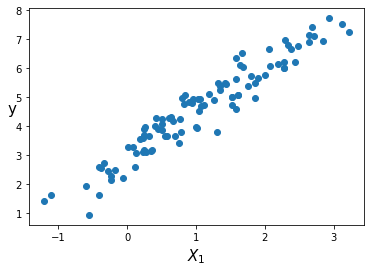

In [3]:
_ = plt.plot(X[:, 1], y, 'o')
_ = plt.xlabel(r"$X_1$", fontsize=15)
_ = plt.ylabel("y", fontsize=15, rotation=0)

In [4]:
prng = torch.manual_seed(42)
_dataset = utils.data.TensorDataset(X,  y)
train_dataset, test_dataset = utils.data.random_split(_dataset, [80, 20], generator=prng)

batch_size = 1
train_dataloader = utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = utils.data.DataLoader(test_dataset, batch_size)

In [5]:
# initialize weights
prng = torch.manual_seed(1)
weights = torch.randn((2, 1), generator=prng, requires_grad=True)


def model_fn(X):
    return X @ weights

def loss_fn(y, y_hat):
    return torch.sqrt(torch.mean((y - y_hat)**2))


In [6]:
learning_rate = 0.001
epochs = 200
log_epochs = 10

for epoch in range(epochs):
    for features, targets in train_dataloader:

        # forward pass
        predictions = model_fn(features)
        loss = loss_fn(targets, predictions)
        
        # backward pass
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * learning_rate
            weights.grad.zero_()
  
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 2.8105
Epoch 10  Loss 1.4667
Epoch 20  Loss 0.4843
Epoch 30  Loss 0.6915
Epoch 40  Loss 0.5156
Epoch 50  Loss 0.5350
Epoch 60  Loss 0.4026
Epoch 70  Loss 0.1495
Epoch 80  Loss 0.4014
Epoch 90  Loss 0.4421
Epoch 100  Loss 0.0026
Epoch 110  Loss 0.8256
Epoch 120  Loss 0.4330
Epoch 130  Loss 0.0723
Epoch 140  Loss 0.0847
Epoch 150  Loss 0.6586
Epoch 160  Loss 0.4614
Epoch 170  Loss 0.4631
Epoch 180  Loss 0.6623
Epoch 190  Loss 0.0410


In [7]:
print(f'Final Parameters: {weights[:, 0]}')

Final Parameters: tensor([3.1473, 1.4327], grad_fn=<SelectBackward0>)


In [8]:
with torch.no_grad():
    total_loss = torch.zeros((1,1))
    for features, target in test_dataloader:
        predictions = model_fn(features)
        loss = loss_fn(target, predictions)
        total_loss += loss

print(f"Average test loss: {total_loss.item() / len(test_dataloader)}")

Average test loss: 0.3617741584777832


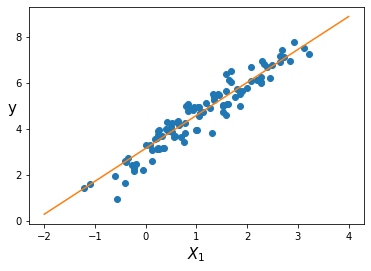

In [9]:
_ = plt.plot(X[:, 1], y, 'o')
_ = plt.xlabel(r"$X_1$", fontsize=15)
_ = plt.ylabel("y", fontsize=15, rotation=0)

new_features = [
    torch.ones((m, 1)),
    torch.linspace(-2, 4, m).reshape((-1, 1))    
]
X_new = torch.cat(new_features, dim=1)

with torch.no_grad():
    y_new = model_fn(X_new)

_ = plt.plot(X_new[:, 1], y_new)

## Model training usng torch.nn and torch.optim

In [10]:
loss_fn = nn.MSELoss()

input_size = 2
output_size = 1
model_fn = nn.Linear(input_size, output_size, bias=False)

optimizer = torch.optim.SGD(model_fn.parameters(), lr=learning_rate)

In [11]:
epochs = 200
log_epochs = 20

for epoch in range(epochs):
    for features, targets in train_dataloader:
        
        # forward pass
        predictions = model_fn(features)        
        loss = loss_fn(predictions, targets)
        
        # backward pass
        loss.backward()        
        optimizer.step()        
        optimizer.zero_grad()    

    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 7.0992
Epoch 20  Loss 0.1573
Epoch 40  Loss 0.0804
Epoch 60  Loss 0.2677
Epoch 80  Loss 0.2518
Epoch 100  Loss 0.6038
Epoch 120  Loss 0.0698
Epoch 140  Loss 0.6364
Epoch 160  Loss 0.1356
Epoch 180  Loss 0.0480


In [12]:
print('Final Parameters:', model_fn.weight)

Final Parameters: Parameter containing:
tensor([[3.0125, 1.5119]], requires_grad=True)


## Building multi-layer perceptrons for classification and regression

In [85]:
class MLPClassifier(nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()

        modules = []
        for hidden_size in hidden_sizes:
            module = nn.Linear(input_size, hidden_size)
            modules.append(module)
            modules.append(nn.ReLU())
            input_size = hidden_size

        modules.append(nn.Linear(hidden_size, output_size))
        modules.append(nn.Softmax(dim=1))

        self.module_list = nn.ModuleList(modules)

    def forward(self, X):
        for f in self.module_list:
            X = f(X)
        return X

    def predict(self, X):
        logits = self.forward(X)
        predictions = logits.argmax(dim=1)
        return predictions


class MLPRegressor(nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()

        modules = []
        for hidden_size in hidden_sizes:
            module = nn.Linear(input_size, hidden_size)
            modules.append(module)
            modules.append(nn.ReLU())
            input_size = hidden_size

        modules.append(nn.Linear(hidden_size, output_size))

        self.module_list = nn.ModuleList(modules)

    def forward(self, X):
        for f in self.module_list:
            X = f(X)
        return X

    def predict(self, X):
        y_hat = self.forward(X)
        return y_hat
        

## Breast Cancer Classification

In [ ]:
datasets.load_breast_cancer?

In [18]:
features, targets = datasets.load_breast_cancer(return_X_y=True, as_frame=True)

In [19]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [20]:
features.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [26]:
random_state = np.random.RandomState(42)
train_features, test_features, train_targets, test_targets = model_selection.train_test_split(
    features,
    targets,
    test_size=0.1,
    random_state=random_state,
)

In [24]:
preprocessing_pipeline = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    preprocessing.FunctionTransformer(lambda X: X.astype(np.float32)),
    preprocessing.FunctionTransformer(lambda X: torch.from_numpy(X)),
)

In [29]:
train_features_tensor = preprocessing_pipeline.fit_transform(train_features)
train_targets_tensor = torch.from_numpy(train_targets.to_numpy())

In [30]:
train_dataset = utils.data.TensorDataset(train_features_tensor, train_targets_tensor)

batch_size = 32
train_dataloader = utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

In [52]:
loss_fn = nn.NLLLoss()

_, input_size = train_features_tensor.shape
output_size = 2
model_fn = MLPClassifier(input_size, [100], output_size)

learning_rate = 1e-2
optimizer = torch.optim.SGD(model_fn.parameters(), lr=learning_rate)

In [53]:
epochs = 200
log_epochs = 20

for epoch in range(epochs):
    for features, targets in train_dataloader:
        
        # forward pass
        predictions = model_fn(features)        
        loss = loss_fn(predictions, targets)
        
        # backward pass
        loss.backward()        
        optimizer.step()        
        optimizer.zero_grad()    

    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss -0.5260
Epoch 20  Loss -0.8587
Epoch 40  Loss -0.9144
Epoch 60  Loss -0.9320
Epoch 80  Loss -0.9282
Epoch 100  Loss -0.9727
Epoch 120  Loss -0.9362
Epoch 140  Loss -0.9541
Epoch 160  Loss -0.9582
Epoch 180  Loss -0.9512


### Evaluating the model on the test set

In [54]:
test_features_tensor = preprocessing_pipeline.transform(test_features)
test_targets_tensor = torch.from_numpy(test_targets.to_numpy())

In [61]:
with torch.no_grad():
  predictions_tensor = model_fn.predict(test_features_tensor)

In [64]:
accuracy = torchmetrics.Accuracy()
accuracy(predictions_tensor, test_targets_tensor)

tensor(0.9474)

### Saving a PyTorch model

In [110]:
RESULTS_DIR = pathlib.Path("./results")
RESULTS_DIR.mkdir(exist_ok=True)

torch.save(model_fn, RESULTS_DIR / "classifier.ckpt")

## Predicting house prices

In [68]:
datasets.fetch_california_housing?

In [87]:
features, targets = datasets.fetch_california_housing(return_X_y=True, as_frame=True)

In [88]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [89]:
features.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [90]:
random_state = np.random.RandomState(42)
train_features, test_features, train_targets, test_targets = model_selection.train_test_split(
    features,
    targets,
    test_size=0.1,
    random_state=random_state,
)

In [91]:
preprocessing_pipeline = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    preprocessing.FunctionTransformer(lambda X: X.astype(np.float32)),
    preprocessing.FunctionTransformer(lambda X: torch.from_numpy(X)),
)

In [99]:
train_features_tensor = preprocessing_pipeline.fit_transform(train_features)
train_targets_tensor = torch.from_numpy(train_targets.to_numpy().astype(np.float32).reshape(-1, 1))

In [100]:
train_dataset = utils.data.TensorDataset(train_features_tensor, train_targets_tensor)

batch_size = 32
train_dataloader = utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

In [101]:
loss_fn = nn.MSELoss()

_, input_size = train_features_tensor.shape
output_size = 1
model_fn = MLPRegressor(input_size, [100], output_size)

learning_rate = 1e-2
optimizer = torch.optim.SGD(model_fn.parameters(), lr=learning_rate)

In [102]:
epochs = 200
log_epochs = 20

for epoch in range(epochs):
    for features, targets in train_dataloader:
        
        # forward pass
        predictions = model_fn(features)        
        loss = loss_fn(predictions, targets)
        
        # backward pass
        loss.backward()        
        optimizer.step()        
        optimizer.zero_grad()    

    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 0.3635
Epoch 20  Loss 0.2243
Epoch 40  Loss 0.3632
Epoch 60  Loss 0.1529
Epoch 80  Loss 0.4890
Epoch 100  Loss 0.1874
Epoch 120  Loss 0.1134
Epoch 140  Loss 0.4617
Epoch 160  Loss 0.0874
Epoch 180  Loss 0.1992


In [103]:
test_features_tensor = preprocessing_pipeline.transform(test_features)
test_targets_tensor = torch.from_numpy(test_targets.to_numpy().astype(np.float32).reshape(-1, 1))

In [104]:
with torch.no_grad():
  predictions_tensor = model_fn.predict(test_features_tensor)

In [105]:
loss_fn(predictions_tensor, test_targets_tensor)

tensor(0.3119)